# GPU and Drive import

In [ ]:
#Installing GPU 

!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=664effbfdda0b3ed11b2b8c8dddc083fd6ab6d3f0aea99db6a25579bdd62b714
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data upload

In [ ]:
#To Access .tar dataset - Training

import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/A2/train_and_val_set.tar')
my_tar.extractall('./TrainData') # specify which folder to extract to
my_tar.close()

In [ ]:
#To Access .tar dataset - Testing


my_tar = tarfile.open('/content/drive/MyDrive/A2/test_set.tar')
my_tar.extractall('./TestData') # specify which folder to extract to
my_tar.close()

# Data preprocessing

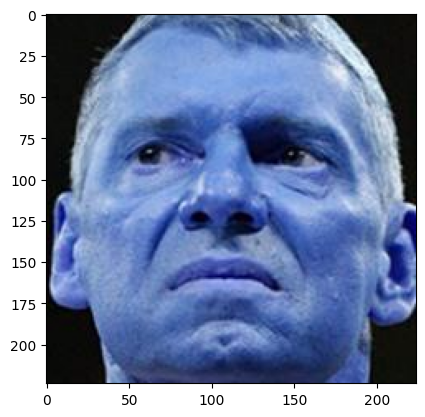

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import glob

#loading image paths from two different directories 
train_data_path = '/content/TrainData/train_set/images/*'
test_data_path = '/content/TestData/val_set/images/*'
train_image_paths = []
test_image_paths=[]
for data_path in glob.glob(train_data_path):
       train_image_paths.append(data_path)
for data_path in glob.glob(test_data_path):
       test_image_paths.append(data_path)

# shuffle the order of the images
random.shuffle(train_image_paths)
image = cv2.imread(test_image_paths[0])
plt.imshow(image)

In [ ]:
#Splitting the Training_Val data into 80 and 20 for training and validation respectively
train_image_allPath = train_image_paths
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

In [ ]:
print(len(train_image_paths))

230120


In [ ]:
print(len(valid_image_paths))

57531


In [ ]:
print(len(train_image_allPath))

287651


In [ ]:
#PreProcessing Image Data
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import center_crop
from torchvision.transforms.transforms import RandomVerticalFlip

img_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize(size=(299,299)), #Resize the image to 299x299 pixels
        transforms.RandomHorizontalFlip(), #Apply a random horizontal flip (with a probability of 0.5) to the image
        transforms.RandomVerticalFlip(), #Apply a random vertical flip (with a probability of 0.5) to the image
        transforms.CenterCrop(299), #Apply a center crop to the image with a size of 299x299 pixels
        transforms.ToTensor(), #Convert the image to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #Normalize the image with the mean and standard deviation values of ImageNet
        ]),

    'validation':
    transforms.Compose([
        transforms.Resize(size=(299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=(299,299)),
        transforms.ToTensor(),
        #transforms.RandomVerticalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ]),
     }

# Integrating Arousal, Valence, Expression with images

In [ ]:
from torch.utils.data import Dataset
from functools import lru_cache
from PIL import Image
import numpy as np

#An interface for loading and preprocessing image data
#Used as a data loader for a PyTorch model

class ImageDataSet(Dataset):
    def __init__(self, image_paths,path, transform=False):
        self.image_paths = image_paths
        self.path=path
        self.transform = transform

    def __len__(self):
        return len(self.image_paths) ##number of images in the dataset    
    @lru_cache()
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        img = Image.open(image_filepath)
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        t=image_filepath.split('/')[-1]
        t=t.split('.')[0]

#loads the label data from the corresponding .npy files
#There are three labels for each image: expression, arousal, and valence

        ExpressionLabel=np.load(self.path+t+'_exp.npy') 
        ExpressionLabel=ExpressionLabel.astype(np.float32)
        ExpressionLabel=torch.from_numpy(ExpressionLabel)
        ExpressionLabel = ExpressionLabel.type(torch.LongTensor)

        ArousalLabel=np.load(self.path+t+'_aro.npy') #arousal
        ArousalLabel=ArousalLabel.astype(np.float32)
        ArousalLabel=torch.from_numpy(ArousalLabel)
        ArousalLabel = ArousalLabel.type(torch.FloatTensor)

        ValenceLabel=np.load(self.path+t+'_val.npy') #Ind
        ValenceLabel=ValenceLabel.astype(np.float32)
        ValenceLabel=torch.from_numpy(ValenceLabel)
        ValenceLabel = ValenceLabel.type(torch.FloatTensor)


        if self.transform is not None:
            rgbimg = self.transform(rgbimg)
        sample = {'image':rgbimg, 'labels': {'exp':ExpressionLabel, 'arousal':ArousalLabel, 'val':ValenceLabel}}
   
        return sample #the method returns a dictionary containing the preprocessed image tensor and the label data as another dictionary

In [ ]:
#Creating an Instance of ImageDataset Class

#alldata= ImageDataSet(train_image_allPath,'/content/TrainData/train_set/annotations/',None)

train_dataset = ImageDataSet(train_image_paths,'/content/TrainData/train_set/annotations/',transform=img_transforms['train'])
valid_dataset = ImageDataSet(valid_image_paths,'/content/TrainData/train_set/annotations/',transform=img_transforms['validation'])
test_dataset = ImageDataSet(test_image_paths,'/content/TestData/val_set/annotations/',transform=img_transforms['test'])

In [ ]:
import torch

def countall(adata):
  count=[0,0,0,0,0,0,0,0]
  for i in adata:
     count[i['labels']['exp']]=count[i['labels']['exp']]+1
  return count
"""
def weight(adata):
  count=countall(adata)
  weigh_all = [0,0,0,0,0,0,0,0]
  j=0
  for i in count:
    weigh_all[j]=1./i
    j=j+1
  j=0
  class_weights_all= [0]*len(adata)
  for k in adata:
    class_weights_all[j] = weigh_all[k['labels']['exp']]
    j=j+1
  return class_weights_all
class_weights_all=weight(train_dataset)
train_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True)
class_weights_all=weight(valid_dataset)
valid_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True)
"""
nSamples=countall(train_dataset)
t=min(nSamples)

# Transfer Learning

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

NormalizedWeights=torch.tensor([1.6711e-05, 9.3002e-06, 4.9097e-05, 8.8199e-05, 1.9646e-04, 3.2394e-04,5.0421e-05, 3.2906e-04])
#normedWeights = normedWeights.to(torch.device("cpu"))
NormalizedWeights = NormalizedWeights.to(torch.device(device))

In [ ]:
NormalizedWeights = [t/x for x in nSamples]
NormalizedWeights = torch.FloatTensor(NormalizedWeights)
NormalizedWeights = NormalizedWeights.to(torch.device(device))

print(NormalizedWeights)

tensor([0.0504, 0.0281, 0.1476, 0.2684, 0.5910, 0.9957, 0.1516, 1.0000],
       device='cuda:0')


In [ ]:
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_dataset,batch_size=32,num_workers=4,shuffle=True),
    'validation':torch.utils.data.DataLoader(valid_dataset,batch_size=32,num_workers=4,shuffle=True),
     'test': torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True,num_workers=4)
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
!pip install timm
import timm # It has pre-trained models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00


In [ ]:
from torch import nn

class Xception(nn.Module):
    def __init__(self, exp, arousal, val):
        super().__init__()
        self.resnet = timm.create_model('xception41', pretrained=True,num_classes=0)

        cnr=0
        
        for param in self.resnet.parameters():
                       cnr=cnr+1
                       if(cnr<251):
                          param.requires_grad = False        
       
        self.exp = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, out_features=exp)
        )
        self.arousal = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, out_features=arousal)
        )
        self.val = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(2048, out_features=val)
        )
    def forward(self, x):
        x = self.resnet(x)
        

        return {
            'exp': self.exp(x),
            'arousal': self.arousal(x),
            'val': self.val(x)
        }

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


#maps the names of the output tensors of the model to their actual output tensors
def criterion(loss,loss_func,outputs,pictures):
  losses = 0
  for i, key in enumerate(outputs):
   if(key=='exp'):
      losses += loss_func(outputs[key],pictures[0])#.cuda()) 
   if(key=='arousal'):
      t= pictures[1].view(len(pictures[1]),1)
      losses += loss(outputs[key],t)
   if(key=='val'):
      t= pictures[2].view(len(pictures[2]),1)
      losses += loss(outputs[key],t) 
      

  return losses

#flatten the lists and convert them to NumPy arrays
def calculate(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])

  print(classification_report(targets2, preds2))
  acc = accuracy_score(targets2, preds2)
  return acc

# Model Training

In [ ]:
TrainingLoss = []
ValidationLoss = []
TestingAccuracy = []
ValidationAccuracy=[]

from torch.cuda.amp import GradScaler, autocast

def train(n_epochs, loaders, model, optimizer,scheduler, lossl2,loss_func, use_cuda, save_path):
    scaler = GradScaler()
    gradient_accumulations = 16

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        tpreds =[]
        ttargets = []
        vpreds=[]
        vtargets=[]
  
        ###################
        # training the model #
        ###################
        model.train()

        for batch_idx, (data) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
            else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
          

            with autocast():
                output = model(img)
                pred = output['exp'].max(1, keepdim=True)[1]
                loss = criterion(lossl2,loss_func,output, [exp,aro,val])
            scaler.scale(loss / gradient_accumulations).backward()
            if (batch_idx + 1) % gradient_accumulations == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

          #  loss.backward()
           # optimizer.step()
            tpreds.append(pred)
            ttargets.append(exp)
       
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (float(loss.data) - train_loss))

        ######################    
        # validating the model #
        ######################
        model.eval()
        
        for batch_idx, (data) in enumerate(loaders['validation']):
            if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
            else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
          
            output = model(img)
            pred = output['exp'].max(1, keepdim=True)[1]
            loss = criterion(lossl2,loss_func,output, [exp,aro,val])
            vpreds.append(pred)
            vtargets.append(exp)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (float(loss.data) - valid_loss))
        
        train_loss = train_loss/len(train_dataset)
        valid_loss = valid_loss/len(valid_dataset)

        TrainingLoss.append(train_loss)
        ValidationLoss.append(valid_loss)
        
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss
                 ))
        ta=calculate(tpreds,ttargets)
        va=calculate(vpreds,vtargets)
        TestingAccuracy.append(ta)
        ValidationAccuracy.append(va)
        #scheduler.step()

      
        
        
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            valid_loss_min = valid_loss
           
    # return trained model
    return model

In [ ]:
from torch.optim import lr_scheduler
from torch import optim

use_cuda = torch.cuda.is_available()
model = Xception(8,1,1)
if use_cuda:
    model = model.cuda()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_xception_41-e6439c97.pth" to /root/.cache/torch/hub/checkpoints/tf_xception_41-e6439c97.pth


In [ ]:
model

Xception(
  (resnet): XceptionAligned(
    (stem): Sequential(
      (0): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (1): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
    )
    (blocks): Sequential(
      (0): XceptionModule(
        (shortcut): ConvNormAct(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (bn): BatchNormAct2d(
            128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [ ]:
# selecting loss function
criterion_transfer = nn.CrossEntropyLoss(NormalizedWeights)
loss_fn = nn.L1Loss()

In [ ]:
#using Adam classifier
optimizer_transfer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=4, gamma=0.1)

In [ ]:
epoch= 3
model = train(epoch, loaders_transfer, model, optimizer_transfer,exp_lr_scheduler,loss_fn, criterion_transfer, use_cuda, '/content/drive/MyDrive/modelA.pt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 	Training Loss: 0.000023 	Validation Loss: 0.000043 
              precision    recall  f1-score   support

           0       0.47      0.23      0.31     59944
           1       0.76      0.45      0.56    107544
           2       0.18      0.19      0.18     20356
           3       0.13      0.28      0.18     11248
           4       0.07      0.26      0.10      5084
           5       0.02      0.17      0.04      3047
           6       0.19      0.25      0.21     19894
           7       0.02      0.18      0.04      3003

    accuracy                           0.33    230120
   macro avg       0.23      0.25      0.20    230120
weighted avg       0.52      0.33      0.39    230120

              precision    recall  f1-score   support

           0       0.48      0.36      0.41     14930
           1       0.80      0.51      0.62     26871
           2       0.21      0.32      0.25      5103
           3       0.17      0.27      0.21      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 2 	Training Loss: 0.000011 	Validation Loss: 0.000044 
              precision    recall  f1-score   support

           0       0.48      0.26      0.34     59944
           1       0.77      0.49      0.60    107544
           2       0.20      0.21      0.21     20356
           3       0.15      0.30      0.20     11248
           4       0.08      0.28      0.12      5084
           5       0.03      0.18      0.05      3047
           6       0.20      0.26      0.23     19894
           7       0.03      0.19      0.05      3003

    accuracy                           0.37    230120
   macro avg       0.24      0.27      0.22    230120
weighted avg       0.53      0.37      0.42    230120

              precision    recall  f1-score   support

           0       0.50      0.37      0.43     14930
           1       0.77      0.57      0.66     26871
           2       0.26      0.17      0.20      5103
           3       0.18      0.38      0.25      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 3 	Training Loss: 0.000011 	Validation Loss: 0.000042 
              precision    recall  f1-score   support

           0       0.48      0.26      0.34     59944
           1       0.77      0.50      0.60    107544
           2       0.21      0.21      0.21     20356
           3       0.15      0.30      0.20     11248
           4       0.08      0.28      0.13      5084
           5       0.03      0.18      0.05      3047
           6       0.20      0.27      0.23     19894
           7       0.03      0.19      0.05      3003

    accuracy                           0.37    230120
   macro avg       0.24      0.28      0.23    230120
weighted avg       0.53      0.37      0.42    230120

              precision    recall  f1-score   support

           0       0.52      0.24      0.33     14930
           1       0.78      0.55      0.65     26871
           2       0.22      0.18      0.20      5103
           3       0.15      0.32      0.21      2842
           4    

# Evaluation Metrics

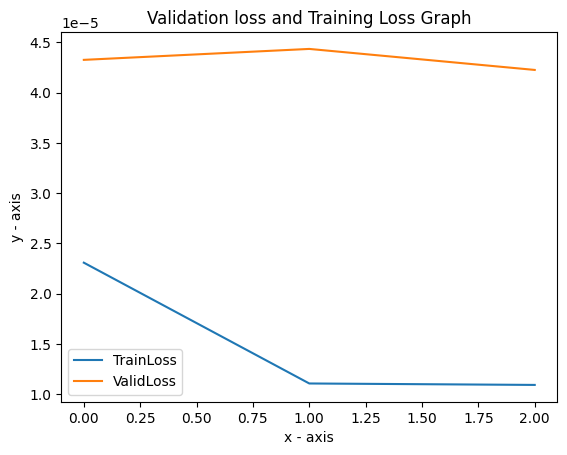

In [ ]:
x=list(range(0, len(TrainingLoss)))
plt.plot(x,TrainingLoss, label = "TrainLoss")
plt.plot(x,ValidationLoss, label = "ValidLoss")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Validation loss and Training Loss Graph')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

In [ ]:
import torch
checkpoint = torch.load('/content/drive/MyDrive/modelA.pt', map_location='cpu')
model.load_state_dict(checkpoint)
model = model.cuda()

In [ ]:
def test(loaders, model, lossl2,loss_func, use_cuda):
    
    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []
    apreds=[]
    atargets=[]
    vpreds=[]
    vtargets=[]

    model.eval()
    model.zero_grad()
    noItoShow = 0
    nooItoShow=0
    f, axarr = plt.subplots(2,2)
    for batch_idx, (data) in enumerate(loaders['test']):
           if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
           else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
           output = model(img.detach())
           pred = output['exp'].max(1, keepdim=True)[1]
           arousal=output['arousal']
           valence = output['val']
           preds.append(pred.detach())
           targets.append(exp.detach())
           apreds.append(output['arousal'])
           atargets.append(aro)
           vpreds.append(output['val'])
           vtargets.append(val)
           if noItoShow<2:
            if(pred[0]!=exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
             # plt.subplot(1, 2, noItoShow) # row 1, col 2 index 1
              axarr[0,noItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[0,noItoShow].set_title("MissClassified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              noItoShow = noItoShow+1
           if nooItoShow<2:
            if(pred[0]==exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
              axarr[1,nooItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[1,nooItoShow].set_title("Correctly Classified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              nooItoShow = nooItoShow+1
            

            

           
           #test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
           #correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
           #total += data.size(0)
    
    return preds, targets, apreds, atargets, vpreds, vtargets

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([4], device='cuda:0')
tensor(3, device='cuda:0')


tensor([2], device='cuda:0')
tensor(5, device='cuda:0')


tensor([1], device='cuda:0')
tensor(1, device='cuda:0')


tensor([6], device='cuda:0')
tensor(6, device='cuda:0')


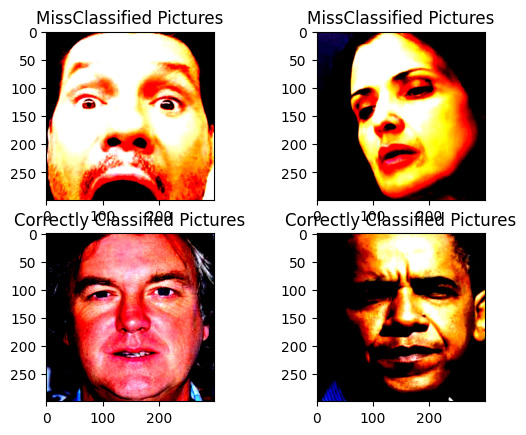

In [ ]:
preds, targets, apreds, atargets, vpreds, vtargets = test(loaders_transfer, model,loss_fn, criterion_transfer, use_cuda)

In [ ]:
calculate(preds,targets)

              precision    recall  f1-score   support

           0       0.27      0.27      0.27       500
           1       0.34      0.61      0.44       500
           2       0.25      0.16      0.20       500
           3       0.33      0.29      0.31       500
           4       0.35      0.50      0.41       500
           5       0.32      0.15      0.21       500
           6       0.28      0.32      0.30       500
           7       0.30      0.18      0.22       499

    accuracy                           0.31      3999
   macro avg       0.30      0.31      0.29      3999
weighted avg       0.30      0.31      0.29      3999



0.3108277069267317

In [ ]:
from scipy.stats import pearsonr

def calculateRMSE(ppreds,cpreds):
  criterion = nn.MSELoss()
  preds2, targets2 = [],[]
  loss=0
  for i,k in zip(ppreds,cpreds):
      for j in range(len(i)):
        preds2.append(i.detach().cpu().numpy()[j].item())
        targets2.append(k.detach().cpu().numpy()[j].item())
  loss=torch.sqrt(criterion(torch.Tensor(preds2),torch.Tensor(targets2)))
  print("RMSE: %.3f"% float(loss))
  print("SAGR: %.3f"% float(calculateSAGR(preds2, targets2)))
  corr, _ = np.corrcoef(preds2, targets2)
  print("Correlation:", corr)
  c=concordance_correlation_coefficient(targets2, preds2)
  print("concordance_correlation_coefficient: %.3f"% float(c))

  return loss,corr,c

In [ ]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

In [ ]:
def calculateSAGR(y_true, y_pred):
  t1=np.sign(y_true)
  t2= np.sign(y_pred)
  count=0
  for x,y in zip(t1,t2):
    if(x==y):
      count=count+1
  return count/len(y_true)

In [ ]:
print('Evaluation Measure for Valence')
vr=[vl,vcor,lvcon]=calculateRMSE(vpreds,vtargets)
print('Evaluation Measure for Arousal')
ar=[al,acor,acon]=calculateRMSE(apreds,atargets)

Evaluation Measure for Valence
RMSE: 0.606
SAGR: 0.422
Correlation: [1.         0.21371693]
concordance_correlation_coefficient: 0.118
Evaluation Measure for Arousal
RMSE: 0.459
SAGR: 0.736
Correlation: [1.         0.13147325]
concordance_correlation_coefficient: 0.032


In [ ]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  auc_dict={}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc
    pre,recall,_   = precision_recall_curve(new_actual_class, new_pred_class)
    auc_dict[per_class] = auc(recall, pre)

  return roc_auc_dict,auc_dict

In [ ]:
#! /usr/bin/env python
# -*- coding: utf-8
'''
Python implementation of Krippendorff's alpha -- inter-rater reliability
(c)2011-17 Thomas Grill (http://grrrr.org)
Python version >= 2.4 required
'''

from __future__ import print_function
try:
    import numpy as np
except ImportError:
    np = None


def nominal_metric(a, b):
    return a != b


def interval_metric(a, b):
    return (a-b)**2


def ratio_metric(a, b):
    return ((a-b)/(a+b))**2


def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or 
    it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.

In [ ]:
from sklearn.metrics import cohen_kappa_score,roc_curve,roc_auc_score,auc,precision_recall_curve
#import simpledorff

def calc(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])
  print("Cohens Kappa Score: %.3f"% float(cohen_kappa_score(targets2,preds2)))
  weighted_roc_auc,aoc_recallauc = roc_auc_score_multiclass(targets2, preds2)
  print("Area Under Curve: %.3f" % float(sum(weighted_roc_auc.values())/8))
  print("AUC – Precision Recall: %.3f" % float(sum(aoc_recallauc.values())/8))
  lis = [targets2,preds2]
  print("nominal metric: %.3f" % krippendorff_alpha(lis, nominal_metric, missing_items=None))


calc(preds,targets)

Cohens Kappa Score: 0.212
Area Under Curve: 0.606
AUC – Precision Recall: 0.351
nominal metric: 0.207


# RESNET

RESNET

In [ ]:
from torch import nn

class ResnetModel(nn.Module):
    def __init__(self, exp, arousal, val):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)
        for param in self.resnet.parameters():
                       param.requires_grad = False

        """
        cntr=0
        lt=5
        for child in self.resnet.children():
            cntr+=1

            if cntr < lt:
                for param in child.parameters():
                       param.requires_grad = False
        """
        self.model_wo_fc = nn.Sequential(*(list(self.resnet.children())[:-1]))
        

        self.exp = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=exp)
        )
        self.arousal = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=arousal)
        )
        self.val = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=val)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'exp': self.exp(x),
            'arousal': self.arousal(x),
            'val': self.val(x)
        }

In [ ]:
def criterion(loss,loss_func,outputs,pictures):
  losses = 0
  for i, key in enumerate(outputs):
   if(key=='exp'):
      losses += loss_func(outputs[key],pictures[0])#.cuda()) 
   if(key=='arousal'):
      t= pictures[1].view(len(pictures[1]),1)
      losses += loss(outputs[key],t)
   if(key=='val'):
      t= pictures[2].view(len(pictures[2]),1)
      losses += loss(outputs[key],t) 
      

  return losses

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

def calculate(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])

  print(classification_report(targets2, preds2))
  acc = accuracy_score(targets2, preds2)
  return acc


trainingLoss = []
validationLoss = []
testAccuracy = []
valAccuracy=[]

from torch.cuda.amp import GradScaler, autocast

def train(n_epochs, loaders, model, optimizer,scheduler, lossl2,loss_func, use_cuda, save_path):
    scaler = GradScaler()
    gradient_accumulations = 16

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        tpreds =[]
        ttargets = []
        vpreds=[]
        vtargets=[]
  
        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
            else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
          


            with autocast():
                output = model(img)
                pred = output['exp'].max(1, keepdim=True)[1]
                loss = criterion(lossl2,loss_func,output, [exp,aro,val])
            scaler.scale(loss / gradient_accumulations).backward()
            if (batch_idx + 1) % gradient_accumulations == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

          #  loss.backward()
           # optimizer.step()
            tpreds.append(pred)
            ttargets.append(exp)
       
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (float(loss.data) - train_loss))

        ######################    
        # validating the model #
        ######################
        model.eval()
        
        for batch_idx, (data) in enumerate(loaders['validation']):
            if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
            else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
          
            output = model(img)
            pred = output['exp'].max(1, keepdim=True)[1]
            loss = criterion(lossl2,loss_func,output, [exp,aro,val])
            vpreds.append(pred)
            vtargets.append(exp)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (float(loss.data) - valid_loss))
        
        train_loss = train_loss/len(train_dataset)
        valid_loss = valid_loss/len(valid_dataset)

        trainingLoss.append(train_loss)
        validationLoss.append(valid_loss)
        
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
            epoch, 
            train_loss,
            valid_loss
                 ))
        ta=calculate(tpreds,ttargets)
        va=calculate(vpreds,vtargets)
        testAccuracy.append(ta)
        valAccuracy.append(va)
        scheduler.step()

      
        
        
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            valid_loss_min = valid_loss
           
    # return trained model
    return model

from torch import optim
from torch.optim import lr_scheduler

use_cuda = torch.cuda.is_available()
model_transfer = ResnetModel(8,1,1)

if use_cuda:
    model_transfer = model_transfer.cuda()

# selecting loss function
criterion_transfer = nn.CrossEntropyLoss(NormalizedWeights)
loss_fn = nn.L1Loss()
#using Adam classifier
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=4, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 97.0MB/s]


In [ ]:
#modelI6= 6 iteration model
#modelI10 = 10 iteration model
#modelI20 = 20 iteration model
n_epochs= 6
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer,exp_lr_scheduler,loss_fn, criterion_transfer, use_cuda, '/content/drive/MyDrive/modelI6.pt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 	Training Loss: 0.000012 	Validation Loss: 0.000043 
              precision    recall  f1-score   support

           0       0.37      0.21      0.27     59944
           1       0.69      0.39      0.49    107544
           2       0.14      0.20      0.16     20356
           3       0.11      0.26      0.15     11248
           4       0.06      0.22      0.09      5084
           5       0.02      0.10      0.04      3047
           6       0.15      0.24      0.18     19894
           7       0.02      0.09      0.03      3003

    accuracy                           0.29    230120
   macro avg       0.19      0.21      0.18    230120
weighted avg       0.45      0.29      0.34    230120

              precision    recall  f1-score   support

           0       0.49      0.24      0.32     14930
           1       0.79      0.47      0.59     26871
           2       0.21      0.32      0.25      5103
           3       0.15      0.43      0.23      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 2 	Training Loss: 0.000011 	Validation Loss: 0.000042 
              precision    recall  f1-score   support

           0       0.46      0.28      0.35     59944
           1       0.75      0.49      0.59    107544
           2       0.19      0.23      0.21     20356
           3       0.14      0.32      0.20     11248
           4       0.08      0.28      0.13      5084
           5       0.03      0.11      0.05      3047
           6       0.19      0.30      0.23     19894
           7       0.02      0.11      0.04      3003

    accuracy                           0.37    230120
   macro avg       0.23      0.27      0.22    230120
weighted avg       0.51      0.37      0.42    230120

              precision    recall  f1-score   support

           0       0.52      0.29      0.37     14930
           1       0.77      0.57      0.65     26871
           2       0.22      0.37      0.27      5103
           3       0.17      0.49      0.25      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 3 	Training Loss: 0.000011 	Validation Loss: 0.000042 
              precision    recall  f1-score   support

           0       0.47      0.30      0.37     59944
           1       0.76      0.49      0.60    107544
           2       0.21      0.25      0.23     20356
           3       0.15      0.34      0.21     11248
           4       0.09      0.29      0.14      5084
           5       0.03      0.13      0.06      3047
           6       0.20      0.31      0.24     19894
           7       0.03      0.12      0.04      3003

    accuracy                           0.38    230120
   macro avg       0.24      0.28      0.23    230120
weighted avg       0.52      0.38      0.43    230120

              precision    recall  f1-score   support

           0       0.52      0.32      0.40     14930
           1       0.82      0.51      0.63     26871
           2       0.23      0.32      0.27      5103
           3       0.16      0.42      0.23      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 4 	Training Loss: 0.000011 	Validation Loss: 0.000041 
              precision    recall  f1-score   support

           0       0.48      0.30      0.37     59944
           1       0.77      0.50      0.60    107544
           2       0.21      0.26      0.23     20356
           3       0.16      0.34      0.21     11248
           4       0.10      0.31      0.15      5084
           5       0.04      0.15      0.06      3047
           6       0.20      0.30      0.24     19894
           7       0.03      0.15      0.05      3003

    accuracy                           0.39    230120
   macro avg       0.25      0.29      0.24    230120
weighted avg       0.53      0.39      0.44    230120

              precision    recall  f1-score   support

           0       0.53      0.29      0.38     14930
           1       0.83      0.49      0.61     26871
           2       0.22      0.34      0.27      5103
           3       0.18      0.38      0.25      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 5 	Training Loss: 0.000011 	Validation Loss: 0.000041 
              precision    recall  f1-score   support

           0       0.48      0.31      0.38     59944
           1       0.77      0.51      0.61    107544
           2       0.21      0.26      0.24     20356
           3       0.16      0.35      0.22     11248
           4       0.10      0.32      0.15      5084
           5       0.04      0.15      0.06      3047
           6       0.21      0.31      0.25     19894
           7       0.03      0.15      0.05      3003

    accuracy                           0.40    230120
   macro avg       0.25      0.29      0.25    230120
weighted avg       0.53      0.40      0.44    230120

              precision    recall  f1-score   support

           0       0.51      0.38      0.44     14930
           1       0.78      0.59      0.67     26871
           2       0.24      0.28      0.26      5103
           3       0.18      0.39      0.25      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
x=list(range(0, 16))
# plotting the line 1 points
plt.plot(x,testAccuracy, label = "TrainLoss")
plt.plot(x,valAccuracy, label = "ValidLoss")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Validation Accurcay and Training Accuracy Graph')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

In [ ]:
x=list(range(0, 16))
plt.plot(x,trainingLoss, label = "TrainLoss")
plt.plot(x,validationLoss, label = "ValidLoss")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Validation loss and Training Loss Graph')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/modelI6.pt', map_location='cpu')
model_transfer.load_state_dict(checkpoint)
model_transfer = model_transfer.cuda()

In [ ]:
def test(loaders, model, lossl2,loss_func, use_cuda):
    
    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []
    apreds=[]
    atargets=[]
    vpreds=[]
    vtargets=[]

    model.eval()
    model.zero_grad()
    noItoShow = 0
    nooItoShow=0
    f, axarr = plt.subplots(2,2)
    for batch_idx, (data) in enumerate(loaders['test']):
           if use_cuda:
                img = data['image'].cuda()
                exp = data['labels']['exp'].cuda()
                aro = data['labels']['arousal'].cuda()
                val = data['labels']['val'].cuda()
           else:
                img = data['image']
                exp = data['labels']['exp']
                aro = data['labels']['arousal']
                val = data['labels']['val']
           output = model(img.detach())
           pred = output['exp'].max(1, keepdim=True)[1]
           arousal=output['arousal']
           valence = output['val']
           preds.append(pred.detach())
           targets.append(exp.detach())
           apreds.append(output['arousal'])
           atargets.append(aro)
           vpreds.append(output['val'])
           vtargets.append(val)
           if noItoShow<2:
            if(pred[0]!=exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
             # plt.subplot(1, 2, noItoShow) # row 1, col 2 index 1
              axarr[0,noItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[0,noItoShow].set_title("MissClassified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              noItoShow = noItoShow+1
           if nooItoShow<2:
            if(pred[0]==exp.detach()[0]):
              rgbimg = img.detach().cpu().numpy()[0]
              axarr[1,nooItoShow].imshow(np.transpose(rgbimg, (1, 2, 0)))
              axarr[1,nooItoShow].set_title("Correctly Classified Pictures")
              print(pred[0])
              print(exp.detach()[0])
              nooItoShow = nooItoShow+1
            

            

           
           #test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
           #correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
           #total += data.size(0)
    
    return preds, targets, apreds, atargets, vpreds, vtargets

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([6], device='cuda:0')
tensor(0, device='cuda:0')


tensor([3], device='cuda:0')
tensor(3, device='cuda:0')


tensor([3], device='cuda:0')
tensor(4, device='cuda:0')


tensor([3], device='cuda:0')
tensor(3, device='cuda:0')


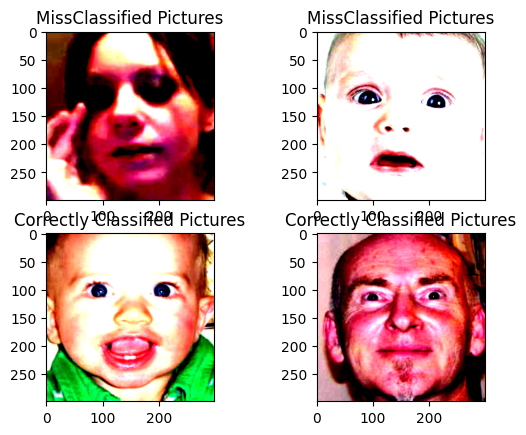

In [ ]:
preds, targets, apreds, atargets, vpreds, vtargets = test(loaders_transfer, model_transfer,loss_fn, criterion_transfer, use_cuda)

In [ ]:
calculate(preds,targets)

              precision    recall  f1-score   support

           0       0.26      0.40      0.32       500
           1       0.34      0.65      0.45       500
           2       0.29      0.26      0.27       500
           3       0.32      0.34      0.33       500
           4       0.43      0.39      0.41       500
           5       0.34      0.07      0.11       500
           6       0.27      0.36      0.31       500
           7       0.35      0.09      0.14       499

    accuracy                           0.32      3999
   macro avg       0.33      0.32      0.29      3999
weighted avg       0.33      0.32      0.29      3999



0.3185796449112278

In [ ]:
from scipy.stats import pearsonr
def calculateRMSE(ppreds,cpreds):
  criterion = nn.MSELoss()
  preds2, targets2 = [],[]
  loss=0
  for i,k in zip(ppreds,cpreds):
      for j in range(len(i)):
        preds2.append(i.detach().cpu().numpy()[j].item())
        targets2.append(k.detach().cpu().numpy()[j].item())
  loss=torch.sqrt(criterion(torch.Tensor(preds2),torch.Tensor(targets2)))
  print("RMSE: %.3f"% float(loss))
  print("SAGR: %.3f"% float(calculateSAGR(preds2, targets2)))
  corr, _ = np.corrcoef(preds2, targets2)
  print("Correlation:", corr)
  c=concordance_correlation_coefficient(targets2, preds2)
  print("concordance_correlation_coefficient: %.3f"% float(c))

  return loss,corr,c

In [ ]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

In [ ]:
def calculateSAGR(y_true, y_pred):
  t1=np.sign(y_true)
  t2= np.sign(y_pred)
  count=0
  for x,y in zip(t1,t2):
    if(x==y):
      count=count+1
  return count/len(y_true)

In [ ]:
print('Evaluation Measure for Valence')
vr=[vl,vcor,lvcon]=calculateRMSE(vpreds,vtargets)
print('Evaluation Measure for Arousal')
ar=[al,acor,acon]=calculateRMSE(apreds,atargets)

Evaluation Measure for Valence
RMSE: 0.598
SAGR: 0.416
Correlation: [1.         0.27434108]
concordance_correlation_coefficient: 0.140
Evaluation Measure for Arousal
RMSE: 0.469
SAGR: 0.769
Correlation: [1.         0.17976774]
concordance_correlation_coefficient: 0.026


In [ ]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  auc_dict={}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc
    pre,recall,_   = precision_recall_curve(new_actual_class, new_pred_class)
    auc_dict[per_class] = auc(recall, pre)

  return roc_auc_dict,auc_dict

In [ ]:
#! /usr/bin/env python
# -*- coding: utf-8
'''
Python implementation of Krippendorff's alpha -- inter-rater reliability
(c)2011-17 Thomas Grill (http://grrrr.org)
Python version >= 2.4 required
'''

from __future__ import print_function
try:
    import numpy as np
except ImportError:
    np = None


def nominal_metric(a, b):
    return a != b


def interval_metric(a, b):
    return (a-b)**2


def ratio_metric(a, b):
    return ((a-b)/(a+b))**2


def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or 
    it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.

In [ ]:
from sklearn.metrics import cohen_kappa_score,roc_curve,roc_auc_score,auc,precision_recall_curve
!pip install simpledorff
import simpledorff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def calc(preds,targets):
  preds2, targets2 = [],[]

  for i in preds:
    for j in range(len(i)):
      preds2.append(i.cpu().numpy()[j])
  for i in targets:
    for j in range(len(i)):
      targets2.append(i.cpu().numpy()[j])
  print("Cohens Kappa Score: %.3f"% float(cohen_kappa_score(targets2,preds2)))
  weighted_roc_auc,aoc_recallauc = roc_auc_score_multiclass(targets2, preds2)
  print("Area Under Curve: %.3f" % float(sum(weighted_roc_auc.values())/8))
  print("AUC – Precision Recall: %.3f" % float(sum(aoc_recallauc.values())/8))
  lis = [targets2,preds2]
  print("nominal metric: %.3f" % krippendorff_alpha(lis, nominal_metric, missing_items=None))

In [ ]:
calc(preds,targets)

Cohens Kappa Score: 0.221
Area Under Curve: 0.611
AUC – Precision Recall: 0.366
nominal metric: 0.213


In [ ]:
#modelI6= 6 iteration model
#modelI10 = 10 iteration model
#modelI20 = 20 iteration model
n_epochs= 10
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer,exp_lr_scheduler,loss_fn, criterion_transfer, use_cuda, '/content/drive/MyDrive/modelI10.pt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 	Training Loss: 0.000011 	Validation Loss: 0.000041 
              precision    recall  f1-score   support

           0       0.48      0.30      0.37     59893
           1       0.77      0.50      0.61    107458
           2       0.21      0.25      0.23     20449
           3       0.16      0.35      0.22     11248
           4       0.10      0.31      0.15      5108
           5       0.04      0.14      0.06      3032
           6       0.20      0.31      0.25     19913
           7       0.03      0.15      0.05      3019

    accuracy                           0.39    230120
   macro avg       0.25      0.29      0.24    230120
weighted avg       0.53      0.39      0.44    230120

              precision    recall  f1-score   support

           0       0.53      0.36      0.43     14981
           1       0.76      0.62      0.68     26957
           2       0.24      0.28      0.26      5010
           3       0.24      0.26      0.25      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 2 	Training Loss: 0.000011 	Validation Loss: 0.000041 
              precision    recall  f1-score   support

           0       0.49      0.30      0.37     59893
           1       0.77      0.50      0.61    107458
           2       0.21      0.26      0.23     20449
           3       0.16      0.35      0.22     11248
           4       0.10      0.32      0.15      5108
           5       0.04      0.14      0.06      3032
           6       0.21      0.30      0.24     19913
           7       0.03      0.16      0.05      3019

    accuracy                           0.39    230120
   macro avg       0.25      0.29      0.24    230120
weighted avg       0.53      0.39      0.44    230120

              precision    recall  f1-score   support

           0       0.51      0.37      0.43     14981
           1       0.84      0.48      0.61     26957
           2       0.21      0.37      0.27      5010
           3       0.19      0.43      0.26      2842
           4    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
